# Práctica 7: Detección de Objetos

Participantes:
- Gerardo León Quintana
- Susana Suárez Mendoza

In [40]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import time
from ultralytics import YOLO
from savedata import SaveData

## Funcionamiento de Gunnar Farnebäck

### **Expansión Polinómica**

Cada vecindario de las dos imágenes se aproxima mediante un polinomio cuadrático de la forma:

$$
f(x)\sim x^T A x + b^T x + c
$$

Donde:

- A es una matriz simétrica que captura la estructura cuadrática local.
- b es un vector que describe las variaciones lineales locales.
- c es una constante.

### **Cómo se calcula**:

- Los coeficientes  se obtienen mediante una aproximación de mínimos cuadrados ponderados en cada vecindario.

---

### **Relación de Desplazamiento**

Para estimar el desplazamiento entre dos cuadros, se compara cómo cambia el polinomio local al moverse de la primera imagen a la segunda. 

$$
d= -\frac{1}{2} A^{-1} (b_2 - b_1)
$$

Donde:

- b_1 y  b_2 son los vectores de los polinomios de los dos cuadros.
- A es el promedio de las matrices  y  de ambos cuadros.

---

### **Optimización Local**

Para manejar el ruido en la estimación, el desplazamiento d(x) se ajusta sobre un vecindario más amplio, minimizando un error ponderado:

$$
\sum_{\Delta x \in I} w(\Delta x) \|A(x + \Delta x)d(x) - \Delta b(x + \Delta x)\|^2
$$

Esto se resuelve eficientemente usando convoluciones separables.

---

### **Modelo Paramétrico de Movimiento**

El algoritmo asume que el campo de desplazamiento sigue un modelo paramétrico, como un modelo afín o de ocho parámetros. Esto permite mayor robustez al reducir los grados de libertad del modelo.

---

### **Iteración y Multi-Escala**

Para manejar grandes desplazamientos y mejorar la precisión, el algoritmo utiliza:

- **Iteración:** Actualiza las estimaciones del desplazamiento en pasos sucesivos.
- **Análisis multi-escala:** Comienza con una estimación en escala gruesa y refina progresivamente en escalas más finas.

### ¿Cómo funciona?

1. **Dividir la imagen en vecindarios pequeños**:
Cada vecindario alrededor de un píxel se aproxima usando una fórmula matemática llamada **polinomio cuadrático**. Piensa en esto como dibujar una forma suave que se ajusta a los valores de brillo de los píxeles cercanos.
2. **Comparar vecindarios en las dos imágenes**:
Si algo se mueve de un cuadro al siguiente, el vecindario en la primera imagen se verá un poco "desplazado" en la segunda. El método calcula este desplazamiento observando cómo cambian las características del polinomio.
3. **Hacerlo más preciso**:
    - No se calcula el movimiento de cada píxel por separado, porque eso sería muy ruidoso. En lugar de eso, se agrupan los datos de un vecindario más grande para encontrar un movimiento promedio.
    - Si el movimiento es grande, el algoritmo usa imágenes más "suaves" (bajas en detalles) para empezar con una estimación aproximada y luego la refina al aumentar la precisión.
4. **Iterar para mejorar**:
El algoritmo repite el proceso varias veces, mejorando la estimación en cada paso.

### Bibliografía

G. Farnebäck, "Two-Frame Motion Estimation Based on Polynomial Expansion," Computer Vision Laboratory, Linköping University, Linköping, Sweden. Disponible: https://www.diva-portal.org/smash/get/diva2:273847/FULLTEXT01.pdf.


## 1. Webcam

In [ ]:
frame = cv.VideoCapture(0)
color = np.random.randint(0, 255, (100, 3))

status, old_frame = frame.read()
if not status:
    print("No se pudo acceder a la cámara.")
    exit()

old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)

h, w = old_gray.shape
result_frame = np.zeros((h, w, 3), dtype=np.uint8)

while True:
    ret, frame2 = frame.read()
    if not ret:
        break

    gray = cv.cvtColor(frame2, cv.COLOR_BGR2GRAY)

    flow = cv.calcOpticalFlowFarneback(old_gray, gray, None, 
                                        pyr_scale=0.5, levels=3, 
                                        winsize=15, iterations=3, 
                                        poly_n=5, poly_sigma=1.2, flags=0)

    step = 16
    y, x = np.mgrid[step//2:h:step, step//2:w:step].reshape(2, -1).astype(int)
    fx, fy = flow[y, x].T
    lines = np.vstack([x, y, x + fx, y + fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines)

    result_frame = cv.addWeighted(result_frame, 0.8, frame2, 0.2, 0)
    for (x1, y1), (x2, y2) in lines:
        cv.line(result_frame, (x1, y1), (x2, y2), (0, 255, 0), 1)
        cv.circle(result_frame, (x1, y1), 1, (0, 255, 0), -1)

    cv.imshow('Flujo óptico - Farneback', result_frame)

    old_gray = gray.copy()

    if cv.waitKey(1) & 0xFF == 27:
        break

frame.release()
cv.destroyAllWindows()

## 2. Video de personas

In [3]:
video = cv.VideoCapture("../videos/people2.mp4")

if not video.isOpened():
    print("No se pudo abrir el video.")
    exit()

ret, old_frame = video.read()
if not ret:
    print("No se pudo leer el primer cuadro del video.")
    exit()

old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)

h, w = old_gray.shape
result_frame = np.zeros((h, w, 3), dtype=np.uint8)

while True:
    ret, frame2 = video.read()
    if not ret:
        break

    gray = cv.cvtColor(frame2, cv.COLOR_BGR2GRAY)

    flow = cv.calcOpticalFlowFarneback(old_gray, gray, None, 
                                       pyr_scale=0.5, levels=3, 
                                       winsize=15, iterations=3, 
                                       poly_n=5, poly_sigma=1.2, flags=0)

    step = 16 
    y, x = np.mgrid[step//2:h:step, step//2:w:step].reshape(2, -1).astype(int)
    fx, fy = flow[y, x].T
    lines = np.vstack([x, y, x + fx, y + fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines)

    result_frame = cv.addWeighted(result_frame, 0.8, frame2, 0.2, 0)
    for (x1, y1), (x2, y2) in lines:
        cv.line(result_frame, (x1, y1), (x2, y2), (0, 255, 0), 1)
        cv.circle(result_frame, (x1, y1), 1, (0, 255, 0), -1)

    cv.imshow('Flujo óptico - Farneback', result_frame)

    old_gray = gray.copy()

    if cv.waitKey(1) & 0xFF == 27:
        break

video.release()
cv.destroyAllWindows()


## 3. YOLO + Gunnar Farnebäck

In [31]:
def get_hand(img, model):
    detections = model(img)
    keypoints = detections[0].keypoints
    keypoint = keypoints[2]
    keypoint_coordinates = keypoint.xy[0]
    right_wrists = keypoint_coordinates[10]
    return right_wrists

In [35]:
video = cv.VideoCapture("../videos/people2.mp4")

status, img = video.read()
size=(img.shape[1], img.shape[0])

fourcc = cv.VideoWriter_fourcc(*'DIVX')
video_out = cv.VideoWriter('../videos/resultado_farneback.mp4', fourcc, 20.0, size)

model = YOLO('./models/yolo11x-pose.pt')

status, old_frame = video.read()

img_bgr = cv.cvtColor(old_frame, cv.COLOR_RGB2BGR)
video_out.write(img_bgr)

hand_point = get_hand(old_frame, model)

old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)
h, w = old_gray.shape
result_frame = np.zeros_like(old_frame)

#trayectoria
tracking_path = [hand_point]
tracking_path_skips = [hand_point]
i = 0
frames = [i]

size = (old_frame.shape[1], old_frame.shape[0])

compute_start = time.time()
while status:
    ret, frame2 = video.read()
    if not ret:
        break

    gray = cv.cvtColor(frame2, cv.COLOR_BGR2GRAY)

    # Calcular flujo óptico de toda la imagen
    flow = cv.calcOpticalFlowFarneback(old_gray, gray, None,
                                       pyr_scale=0.5, levels=3,
                                       winsize=15, iterations=3,
                                       poly_n=5, poly_sigma=1.2, flags=0)

    # Actualizar la posición de la mano usando el flujo óptico
    new_tracked_points = [] # puntos del frame actual
    for (x, y) in [tracking_path[-1]]:
        fx, fy = flow[int(y), int(x)]
        new_x, new_y = x + fx, y + fy
        new_tracked_points.append((new_x, new_y))
        tracking_path.append((new_x, new_y))
        tracking_path_skips.append((new_x, new_y))
    
    i += 1
    frames.append(i)
        
    result_frame = cv.addWeighted(result_frame, 0.8, frame2, 0.2, 0)

    for i in range(1, len(tracking_path)):
        cv.line(result_frame, 
                (int(tracking_path[i-1][0]), int(tracking_path[i-1][1])),
                (int(tracking_path[i][0]), int(tracking_path[i][1])),
                (255, 0, 0), 1)
        
    for (x, y) in new_tracked_points:
        cv.circle(result_frame, (int(x), int(y)), 5, (0, 255, 0), -1)

    cv.imshow('Flujo óptico - Mano', result_frame)

    video_out.write(result_frame)
    old_gray = gray.copy()

    if cv.waitKey(1) & 0xFF == 27:
        break

tracking_path.append(tracking_path[-1])
tracking_path_skips.append(tracking_path[-1])
frames.append(i+1)

compute_end = time.time()
video.release()
cv.destroyAllWindows()



0: 384x640 7 persons, 619.1ms
Speed: 3.5ms preprocess, 619.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


In [36]:
spent_time = compute_end - compute_start
spent_time_min = spent_time / 60
print(f"Time spent: {spent_time} seconds")
print(f"Time spent: {spent_time_min} minutes")

Time spent: 149.5633306503296 seconds
Time spent: 2.492722177505493 minutes


In [38]:
x_coordinates = [float(point[0]) if hasattr(point[0], 'item') else point[0] for point in tracking_path]
y_coordinates = [float(point[1]) if hasattr(point[1], 'item') else point[1] for point in tracking_path]
x_skip = [float(point[0]) if hasattr(point[0], 'item') else point[0] for point in tracking_path_skips]
y_skip = [float(point[1]) if hasattr(point[1], 'item') else point[1] for point in tracking_path_skips]
timestamp = [i for i in range(len(tracking_path))]
speed = np.sqrt(np.diff(x_coordinates)**2 + np.diff(y_coordinates)**2)

data = {
    "x_coordinates": x_coordinates,
    "y_coordinates": y_coordinates,
    "x_skip": x_skip,
    "y_skip": y_skip,
    "time": timestamp,
    "time_frame": frames,
    "speed": speed.tolist(),
    "time_spent": spent_time,
}

savedata = SaveData(data, "tracking_farneback")
savedata.save_data()

Datos guardados en ../resultados\tracking_farneback.txt


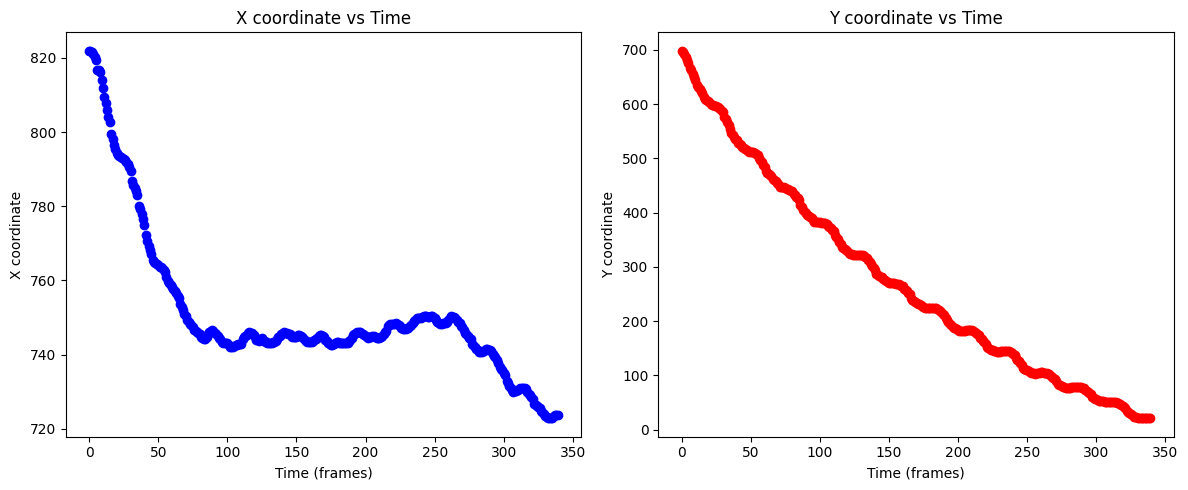

In [28]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(frames, x_skip, label="x(t)", color="blue", marker='o', linestyle='')
plt.xlabel("Time (frames)")
plt.ylabel("X coordinate")
plt.title("X coordinate vs Time")

plt.subplot(1, 2, 2)
plt.plot(frames,y_skip, label="y(t)", color="red", marker='o', linestyle='')
plt.xlabel("Time (frames)")
plt.ylabel("Y coordinate")
plt.title("Y coordinate vs Time")

plt.tight_layout()
plt.show()

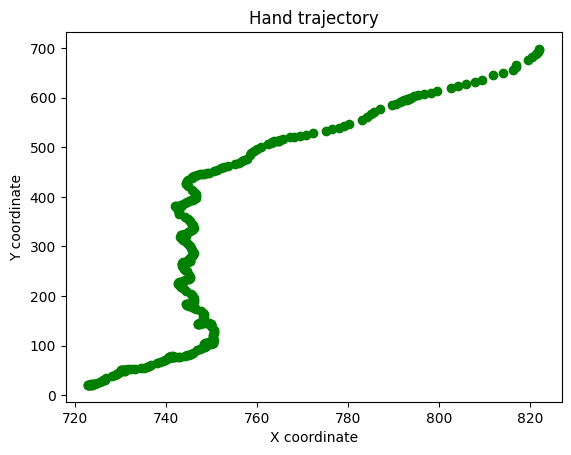

In [29]:
plt.plot(x_skip, y_skip, label="Hand trajectory", color="green", marker='o', linestyle='')
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.title("Hand trajectory")
plt.show()

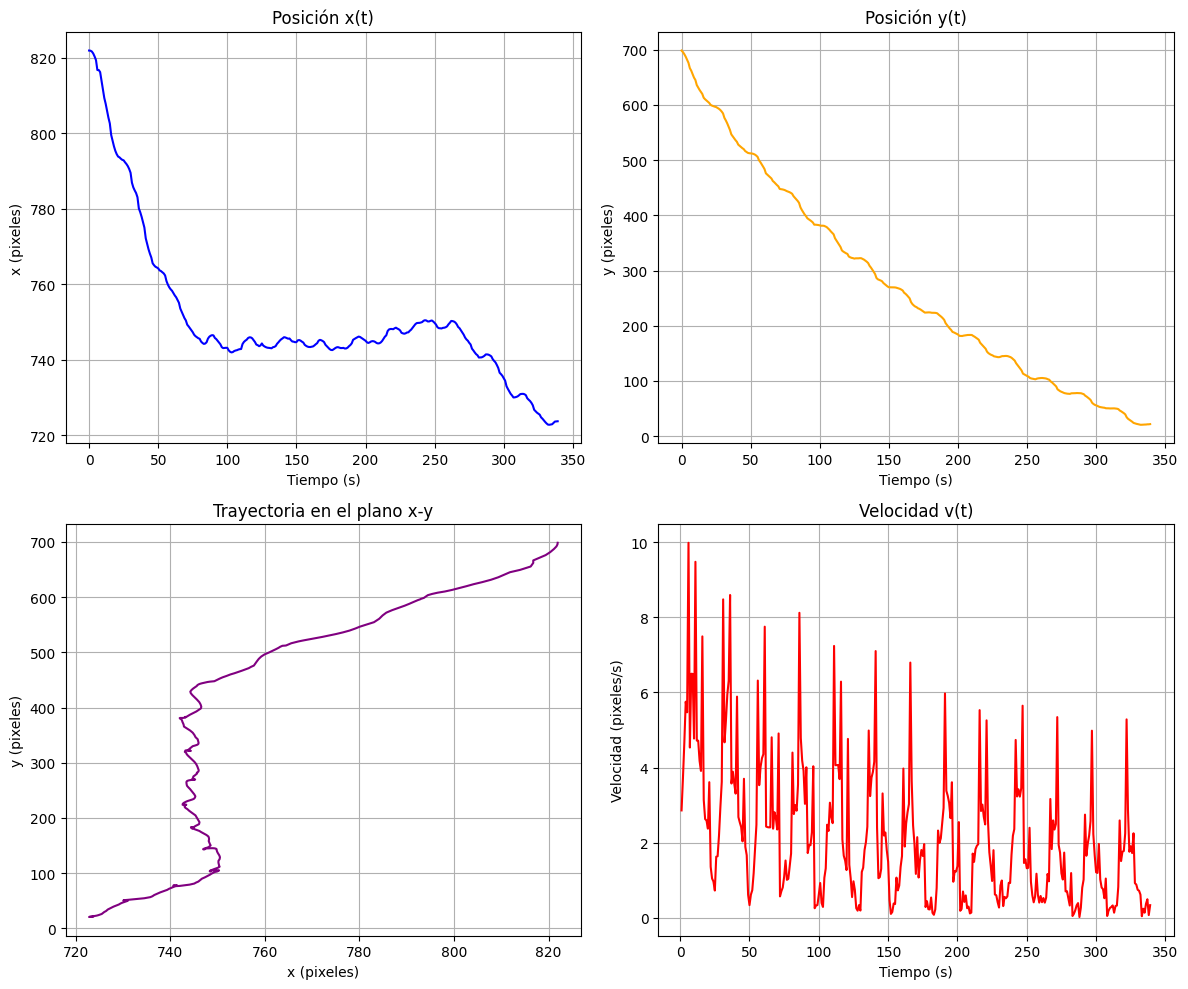

In [30]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(timestamp, x_coordinates, label="x(t)", color="blue")
plt.xlabel("Tiempo (s)")
plt.ylabel("x (pixeles)")
plt.title("Posición x(t)")
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(timestamp, y_coordinates, label="y(t)", color="orange")
plt.xlabel("Tiempo (s)")
plt.ylabel("y (pixeles)")
plt.title("Posición y(t)")
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(x_coordinates, y_coordinates, label="Trayectoria", color="purple")
plt.xlabel("x (pixeles)")
plt.ylabel("y (pixeles)")
plt.title("Trayectoria en el plano x-y")
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(timestamp[1:], speed, label="v(t)", color="red")
plt.xlabel("Tiempo (s)")
plt.ylabel("Velocidad (pixeles/s)")
plt.title("Velocidad v(t)")
plt.grid()

plt.tight_layout()
plt.show()

## 4. Flujo óptico

In [45]:
video = cv.VideoCapture("../videos/people2.mp4")
status, old_frame = video.read()
size = (old_frame.shape[1], old_frame.shape[0])

fourcc = cv.VideoWriter_fourcc(*'DIVX')
video_out = cv.VideoWriter('../videos/result_optical_flow_farneback.mp4', fourcc, 20.0, size)

old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)

hsv = np.zeros_like(old_frame)
hsv[..., 1] = 255

while True:
    status, frame = video.read()
    if not status:
        break

    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    # Calcular el flujo óptico denso
    flow = cv.calcOpticalFlowFarneback(old_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    # Calcular la magnitud y el ángulo del flujo
    mag, ang = cv.cartToPolar(flow[..., 0], flow[..., 1])

    # Codificar el flujo óptico en colores
    hsv[..., 0] = ang * 180 / np.pi / 2  # Dirección del flujo
    hsv[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)  # Magnitud del flujo
    rgb_flow = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)

    # Mostrar el resultado y guardar en el video
    cv.imshow('Flujo Óptico Farneback', rgb_flow)
    video_out.write(rgb_flow)

    # Actualizar el cuadro anterior
    old_gray = gray.copy()

    if cv.waitKey(1) & 0xFF == 27:  # Presiona ESC para salir
        break

video.release()
video_out.release()
cv.destroyAllWindows()

## 5. Flujo óptico de dos imágenes

### 5.1 Personas

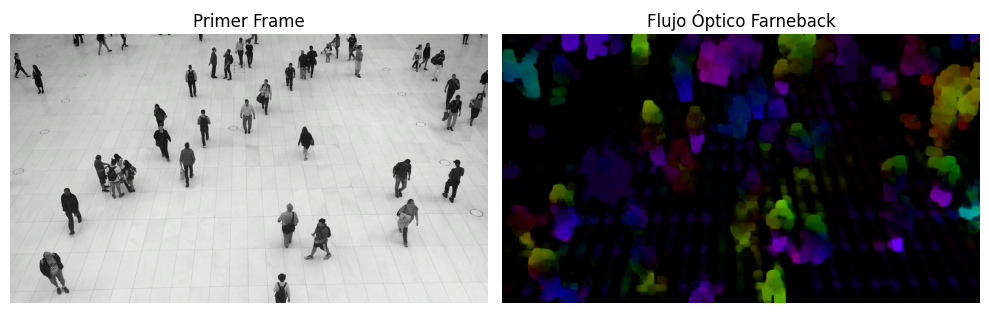

In [47]:
cap = cv.VideoCapture("../videos/people2.mp4")

frame_indices = [50, 200]
frames = []

for i in range(max(frame_indices) + 1):
    ret, frame = cap.read()
    if i in frame_indices:
        frames.append(frame)
    if not ret:
        print(f"No se pudo leer el frame {i}.")
        cap.release()
        exit()

cap.release()

old_gray = cv.cvtColor(frames[0], cv.COLOR_BGR2GRAY)
frame_gray = cv.cvtColor(frames[1], cv.COLOR_BGR2GRAY)

flow = cv.calcOpticalFlowFarneback(old_gray, frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

mag, ang = cv.cartToPolar(flow[..., 0], flow[..., 1])

hsv = np.zeros_like(frames[0])
hsv[..., 1] = 255  # Saturación constante
hsv[..., 0] = ang * 180 / np.pi / 2  # Dirección del flujo
hsv[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)  # Magnitud del flujo
result_rgb = cv.cvtColor(hsv, cv.COLOR_HSV2RGB)

frame_0_rgb = cv.cvtColor(frames[0], cv.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))

# Primer frame
plt.subplot(1, 2, 1)
plt.imshow(frame_0_rgb)
plt.title("Primer Frame")
plt.axis("off")

# Resultado del flujo óptico Farneback
plt.subplot(1, 2, 2)
plt.imshow(result_rgb)
plt.title("Flujo Óptico Farneback")
plt.axis("off")

plt.tight_layout()
plt.show()